In [4]:
%cd /content/drive/MyDrive/well done projects/04-Natural Language Processing/05-Sarcasm Detection

/content/drive/MyDrive/well done projects/04-Natural Language Processing/05-Sarcasm Detection


In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 7.3 MB/s 
     |████████████████████████████████| 212 kB 66.1 MB/s 
     |████████████████████████████████| 86 kB 7.5 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 61.3 MB/s 
     |████████████████████████████████| 140 kB 76.8 MB/s 
     |████████████████████████████████| 596 kB 60.6 MB/s 
     |████████████████████████████████| 127 kB 77.7 MB/s 
     |████████████████████████████████| 144 kB 73.4 MB/s 
     |████████████████████████████████| 94 kB 1.1 MB/s 
     |████████████████████████████████| 271 kB 57.9 MB/s 
     |████████████████████████████████| 112 kB 58.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing ins

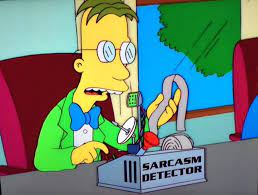<img><br>
Anyone in machine-learning, has at one point in time come across the terms 'transformers' and 'huggingface'. 
The transformer in NLP is a novel architecture that aims to solve sequence-to-sequence tasks while handling long-range dependencies with ease. <br>
NLP-focused startup Hugginface recently released a major update to their popular pytorch transformers library which establishes compatibility between pytorch and tensorflow 2.0 enabling users to easily move from one framework to another during the life of a model for training and evaluation purposes.<br>
This notebook predominantly uses Tensorflow.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re, string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.manifold import TSNE


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from keras.preprocessing import text, sequence
from datasets import load_dataset, DatasetDict
from transformers import DataCollatorWithPadding

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GRU
import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models import Word2Vec
import joblib


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Read the data
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Here is an example of the headline.

In [6]:
df['headline'].iloc[0]

'thirtysomething scientists unveil doomsday clock of hair loss'

The article link column is rather useless for what we are trying to achieve. So we will drop it. Have our X variable as the headline text, and the y variable as the is_sarcastic column.

In [7]:
# Drop the article link column
df.drop(columns='article_link', inplace=True)

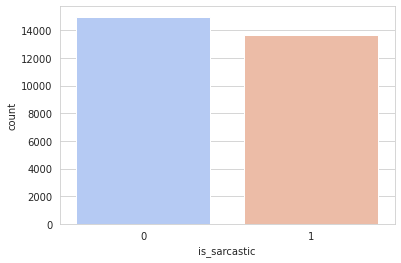

In [8]:
# Check the distribution of the y variable
sns.countplot(df['is_sarcastic'], palette='coolwarm')

The distribution of our data seems to be almost equal. Therefore, we do not need to employ data balancing tools. We will proceed to our data exploration.

# Data Exploration

(-0.5, 1599.5, 799.5, -0.5)

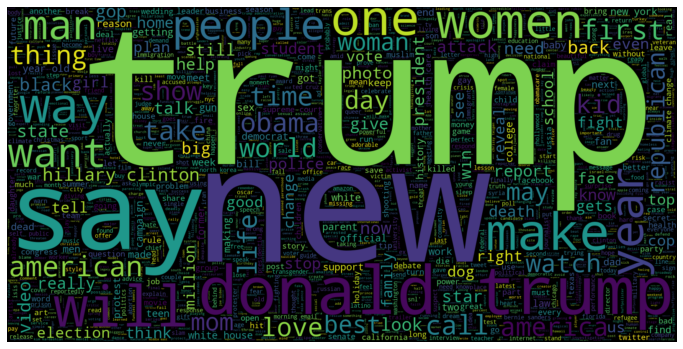

In [9]:
# Wordcloud for non sarcastic labels
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=2000, width=1600, height=800).\
generate(" ".join(df[df['is_sarcastic'] == 0]['headline']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

(-0.5, 1599.5, 799.5, -0.5)

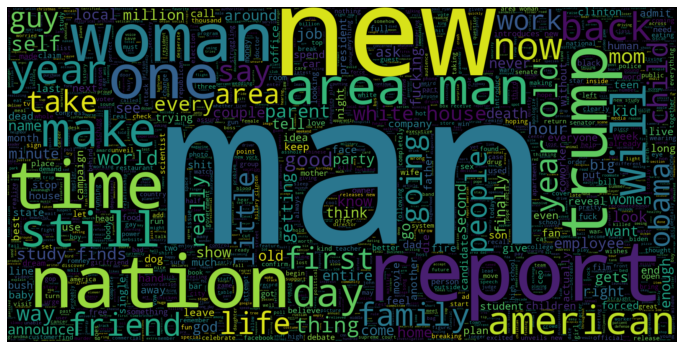

In [10]:
# Wordcloud for sarcastic labels
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=2000, width=1600, height=800).\
generate(" ".join(df[df['is_sarcastic'] == 1]['headline']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

# Model 1: Introduction to word2vec and word embeddings

'Word embeddings' typically refers the representation of a word as a real number or vector representation. Words with similar meaning will usually have vector representations that are close together in the embedding space. This is usually done to capture some sort of relationship in that space, be it meaning, morphology, context, or some other kind of relationship. By encoding word embeddings in a densely populated space, we can represent words numerically in a way that captures them in vectors that have tens or hundreds of dimensions instead of millions like one-hot encoded vectors.<br>
We use word embeddings because words aren't things that computers naturally understand. By encoding them in numerical form, we can apply mathematical rules and do matrix operations to them. 

**Word2vec** is a better successor to the neural probabilistic model. We still use a statistical computation method to learn from a text corpus, however, its method of training is more efficient than just simple embedding training. In our case, we will use the continuous skip-gram that learns an embedding by predicting the surrounding words given the context. The context is the current word. <br>
Word2vec usually leads to high quality embeddings that occupy less space and have low time complexity yet still generate a rich representation. 

We should start by cleaning our data. The following code uses regex.

In [11]:
def text_preprocessing(text):
    #Put it in lower case
    text = text.lower()
    #Remove urls
    pattern_url=r'https?://\S+|www\.\S+'
    text=re.sub(pattern_url, '', text)

    #Remove html
    pattern_html=r'<.*?>'
    text=re.sub(pattern_html, '', text)
              
    #Remove numbers
    pattern_num= r'\d+'
    text=re.sub(pattern_num, '', text)
    
    #Remove hashtags
    pattern_hashtags=r'#\w+'
    text=re.sub(pattern_hashtags,'', text) 

    #Space removal
    text = re.sub(r"\s+"," ",text)

    #Remove punctuation
    text= [char for char in text if char not in string.punctuation]
    text=''.join(text)
    
    #Remove stopwords
    text= [char for char in text.split() if char.lower() not in stopwords.words('english')]
    text=' '.join(text) 

    return text

df['headline'] = df['headline'].progress_apply(text_preprocessing)


  0%|          | 0/28619 [00:00<?, ?it/s]

It is important to split our data before initializing our word embeddings. This is important so as to avoid data leakage. 

In [12]:
# Train test split
X = df['headline']
y = df['is_sarcastic']

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

We will initialize phraser from gensim that extracts common phrases from the corpus. This is important as it identifies bigrams such as 'President Trump', 'New York'. We will add two parameters :
* **min_count-** ignores all words and bigrams with total collected count lower than this. The default value is 5, however, we will use 30 in our case to avoid overloading our word embeddings with words that are not even bigrams
* **threshold-** represents a threshold for forming the phrases (higher means fewer phrases). A phrase of words a and b is accepted if (cnt(a,b) - min_count) * N/(cnt(a) * cnt(b)) > threshold, where N is the total vocabulary size. The default is 10. We will have a higher threshold of 15.

In [13]:
sentences = [sent.split() for sent in X_train]
phrases = Phrases(sentences,threshold = 15, min_count=30)
bigram = Phraser(phrases)
corpus = bigram[sentences]

In [14]:
# Dimensions of vectors that we are generating
EMBEDDING_DIM = 200
w2v_model = Word2Vec(size=100, # dimensionality of word vectors
                 window=4, # max distance btw current and predicted words
                 min_count=5, # ignore words with a lower frequency
                 workers=4, 
                 sg=1, # 1 for skip-gram, 0 for cbow
                 iter=10)

w2v_model.build_vocab(corpus)
w2v_model.train(corpus,
            total_examples = w2v_model.corpus_count,
            epochs=15)

(1648611, 2118705)

We can visualize the high-dimensional word2vec word embeddings using t-SNE. T-SNE is a machine learning algorithm that reduces dimensional space keeping relative pairwise distance between points. The idea is to keep similar words close together on the plane, while maximizing the distance between dissimilar words

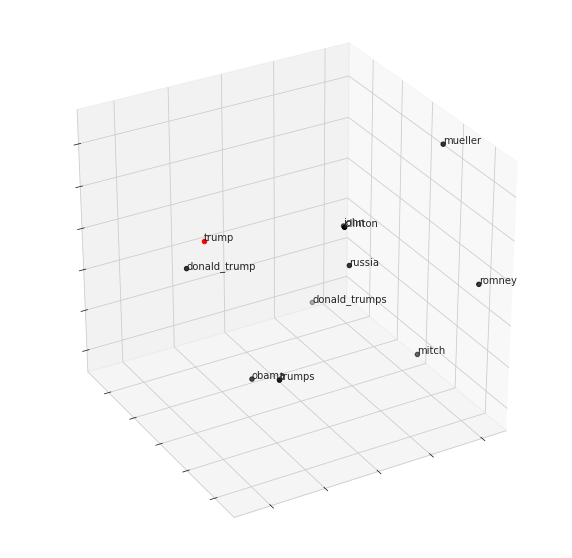

In [15]:
from mpl_toolkits.mplot3d import axes3d
def tsne_plot(word):
  # Word embedding
  sims = [word] + [i[0] for i in w2v_model.wv.most_similar(word, topn=10)]
  X = w2v_model.wv[sims]

  # Dimensionality Reduction
  tsne = TSNE(n_components=3, init='pca')
  X = tsne.fit_transform(X)
  df_tsne = pd.DataFrame(X, index=sims, columns=['x','y','z'])
  df_tsne['input'] = 0
  df_tsne['input'].iloc[0:1] = 1

  # Plot 3D
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')
  ax.view_init(elev=30, azim=-120)
  ax.scatter(df_tsne[df_tsne['input'] == 0]['x'],
              df_tsne[df_tsne['input'] == 0]['y'],
              df_tsne[df_tsne['input'] == 0]['z'], c='black')
  ax.scatter(df_tsne[df_tsne['input'] == 1]['x'],
            df_tsne[df_tsne['input'] == 1]['y'],
            df_tsne[df_tsne['input'] == 1]['z'], c='red')
  ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[],
         yticklabels=[], zticklabels=[])
  for label, row in df_tsne[['x','y','z']].iterrows():
    x, y, z = row
    ax.text(x,y,z, s=label)

tsne_plot('trump')

Our word2vec seems to be performing quite well. Trump is the former president of the United States. We can see basic matching such as his names : trump, trumps, donald_trump. More importantly, we can see that obama, who was also a US president being close to the word. Words such as 'White_house' are also linked to trump. Therefore, we can confidently say that we have successfully created our word embeddings.

In [16]:
len(w2v_model.wv.vocab)

5510

We will now tokenize our corpus. Tokenization is a common task when working with text data. It consists of splitting an entire text into smaller units, also known as tokens. It is the foundation for developing good models.<br>
Here is what the following code does:
* **fit_on_texts:** updates the internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency.
* **texts_to_sequence:** transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.

After that, we will then pad sequences to ensure all sequences in a list have the same length. By default, this is done by padding 0 at the beginning of each sequence until each sequence has the same length as the longest sequence. We will however, pad at the end.<br>
We will also specify our maximum length of sequences as 12. This will truncate any sequence with more than 12 words. This is importance as it reduces the size of our word index.

In [17]:
# Tokenize the  train data
tokenizer = text.Tokenizer(num_words=6000, lower=True)
tokenizer.fit_on_texts(corpus)
vocabulary = tokenizer.word_index

# create sequence
tokenized_train = tokenizer.texts_to_sequences(corpus)
# Padding sequence
x_train = sequence.pad_sequences(tokenized_train, maxlen=12, padding='post',
                                 truncating='post')
print(x_train.shape)

(20033, 12)


Here is a visual of how our sequences look like.

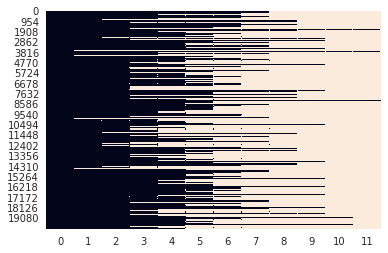

In [18]:
sns.heatmap(x_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

As I had said earlier, it is important tohave your test data on the side to avoid data leakage. We will preprocess our test data the same way, but will not fit_on_texts as we did. 

In [19]:
# Preprocess test data too
sentences = [sent.split() for sent in X_test]

# Detect bigrams and trigrams
phrases = Phrases(sentences, min_count=20)
bigram = Phraser(phrases)

corpus = bigram[sentences]

# create sequence
tokenized_test = tokenizer.texts_to_sequences(corpus)

# Padding sequence
x_test = sequence.pad_sequences(tokenized_test, maxlen=12, padding='post', truncating='post')
print(x_test.shape)

(8586, 12)


In [20]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
# Create weight matrix from word2vec gensim model
def weight_matrix(model, vocab):
  # total vocabulary size plus 0 for unknown words
  vocab_size = len(vocab) + 1
  # Define weight matrix dimensions with all 0
  weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
  # Step vocab, store vectors using the tokenizers integer mapping
  for word, i in vocab.items():
    # update row with vector
    try:
      weight_matrix[i] = model[word]
    # if word not in model then skip and the row stays all 0s
    except:
      pass
    return weight_matrix

# getting embedding vectors from word2vec and using t as weights of non-trainable keras embedding  layer
embedding_vectors = weight_matrix(w2v_model, tokenizer.word_index)

24125


We will still update the weights during training in the embedding layer. I have noted that in this case, it leads to a higher validation accuracy.

In [21]:
model = Sequential()
# trainable embedding layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors],
                    input_length=12, trainable=True))
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.3, dropout=0.3, 
                             return_sequences=True)))
model.add(Bidirectional(GRU(units=32, recurrent_dropout=0.1, dropout=0.1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', 
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 200)           4825000   
                                                                 
 bidirectional (Bidirectiona  (None, 12, 256)          336896    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,217,641
Trainable params: 5,217,641
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(x_train, y_train, batch_size=128, 
                    validation_data=(x_test, y_test), 
                    epochs=2)

Epoch 1/2
157/157 [==============================] - 48s 222ms/step - loss: 0.4995 - acc: 0.7520 - val_loss: 0.4405 - val_acc: 0.7942
Epoch 2/2
157/157 [==============================] - 32s 206ms/step - loss: 0.3114 - acc: 0.8659 - val_loss: 0.4526 - val_acc: 0.7885


In [23]:
joblib.dump(model, 'word2vec_model.pkl')

INFO:tensorflow:Assets written to: ram://f0039bd0-9eae-4f32-a057-427865388a03/assets


['word2vec_model.pkl']

# Model 2: Bert-Huggingface
<img src="https://miro.medium.com/max/700/0*dWNeYrHTi76uhbq5.png"><br>
The huggingface transformers package is an immensely popular python library providing retrained models that are extraordinarily useful for a variety of NLP tasks.


We will load our dataset a fresh using the load_dataset function from huggingface. We will split the data into train, validation and test data. This will then be stored in a DatasetDict object.<br>
We have to specify that we are loading a json file, use the train_test_split function to split the data.

In [24]:
dataset = load_dataset('json',
                       data_files = 'Sarcasm_Headlines_Dataset_v2.json',
                       split='train'
                        )
# Drop the article link column
dataset = dataset.remove_columns('article_link')
# 90% train, 30% test + validation
train_test_valid = dataset.train_test_split(test_size = 0.3)
# Split the 10% test+ valid in half test, half valid
test_valid = train_test_valid['test'].train_test_split(test_size=0.5)

# Make a single datatsetdict
df = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})
df
print(df['train'][0])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9e00a5617b4e000a/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.
{'is_sarcastic': 0, 'headline': "12 gift ideas for couples who don't take themselves too seriously"}


We use the AutoModelForSequenceClassification model instead of the AutoModel which has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (2 in our case), since it dictates the number of outputs the classification head has.<br>
We will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained.

In [25]:
checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
def tokenize_function(example):
  return tokenizer(example['headline'], truncation=True)
tokenized_df = df.map(tokenize_function, batched=True)
tokenized_df

  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['is_sarcastic', 'headline', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20033
    })
    test: Dataset({
        features: ['is_sarcastic', 'headline', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4293
    })
    valid: Dataset({
        features: ['is_sarcastic', 'headline', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4293
    })
})

* **input_ids:** refers to the list of token ids to be fed to a model
* **attention_masks:**  list of indices specifying which tokens should be attended to by the model. The input sequences are denoted by 1 and the padded ones by 0. These masks help to determine between the two.

The function that is responsible for putting together samples inside a batch is called a collate function. The default collator is a function tat will just convert your samples with tf.tensor and concatenate them. This won't be possible in our case since the inputs we have won't all be of the same size. We have deliberately postponed padding, to only apply it as necessary to each batch and avoid over-long inputs with a lot of padding. 

We will use the DataCollatorWithPadding function. It takes a tokenizer when you instantiate it (to know which padding token to use, and whether the model expects padding to be on the left or on the irght of the inputs) and will do everything you need.<br>
We will get samples of varying ength from 32 to 67. Dynamic padding means that the samples in this batch should all be padded to a length of 67, the maximum length inside the batch. Without dynamic padding, all our samples would have to be padded to the maximum length the whole dataset.

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,
                                        return_tensors='tf')

Now that we have our dataset and datacollator, we need to put them together. We could manually load batches and collate them but its a lot of work. We will wrap *to_tf_dataset()* around your dataset with an optional collate function

In [28]:
tf_train_dataset = tokenized_df['train'].to_tf_dataset(
    columns = ['attention_mask', 'input_ids','token_type_ids'],
    label_cols = ['is_sarcastic'],
    shuffle=True,
    collate_fn = data_collator,
    batch_size=8
)
tf_validation_dataset = tokenized_df['valid'].to_tf_dataset(
    columns = ['attention_mask', 'input_ids','token_type_ids'],
    label_cols = ['is_sarcastic'],
    shuffle=False,
    collate_fn = data_collator,
    batch_size=8
)

We will use the TFAutoModelForSequenceClassification class with two labels. We will also use a different learning rate. Adam's learning rate is 1e-3, while transformers have their learning rates around 5e-5. We will do this by lowering the learning rate gradually over the training course. We will use the *Polynomialdecay* learning rate scheduler that linearly decays the learning rate from the initial value to the final value over the course of training.

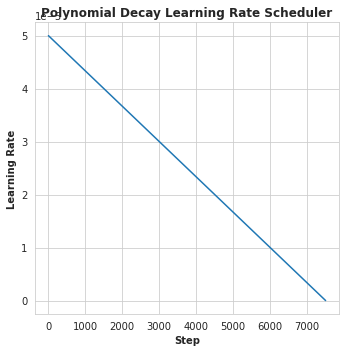

In [29]:
num_epochs = 3
batch_size = 8
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 5e-5,
    end_learning_rate = 0.0,
    decay_steps = num_train_steps
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# We can plot the learning rate
plt.figure(figsize=(5,5))
plt.plot(np.arange(num_train_steps), [lr_scheduler(i) for i in range(num_train_steps)] )
plt.title('Polynomial Decay Learning Rate Scheduler', fontweight='bold')
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Learning Rate', fontweight='bold')
plt.tight_layout()

In [30]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer = opt,
    loss = loss,
    metrics = ['accuracy']
)
history = model.fit(
    tf_train_dataset,
    validation_data = tf_validation_dataset,
    epochs = num_epochs
)

Epoch 1/3
2504/2504 [==============================] - 243s 90ms/step - loss: 0.2643 - accuracy: 0.8909 - val_loss: 0.1934 - val_accuracy: 0.9203
Epoch 2/3
2504/2504 [==============================] - 220s 88ms/step - loss: 0.0882 - accuracy: 0.9683 - val_loss: 0.2068 - val_accuracy: 0.9331
Epoch 3/3
2504/2504 [==============================] - 221s 88ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 0.2907 - val_accuracy: 0.9359


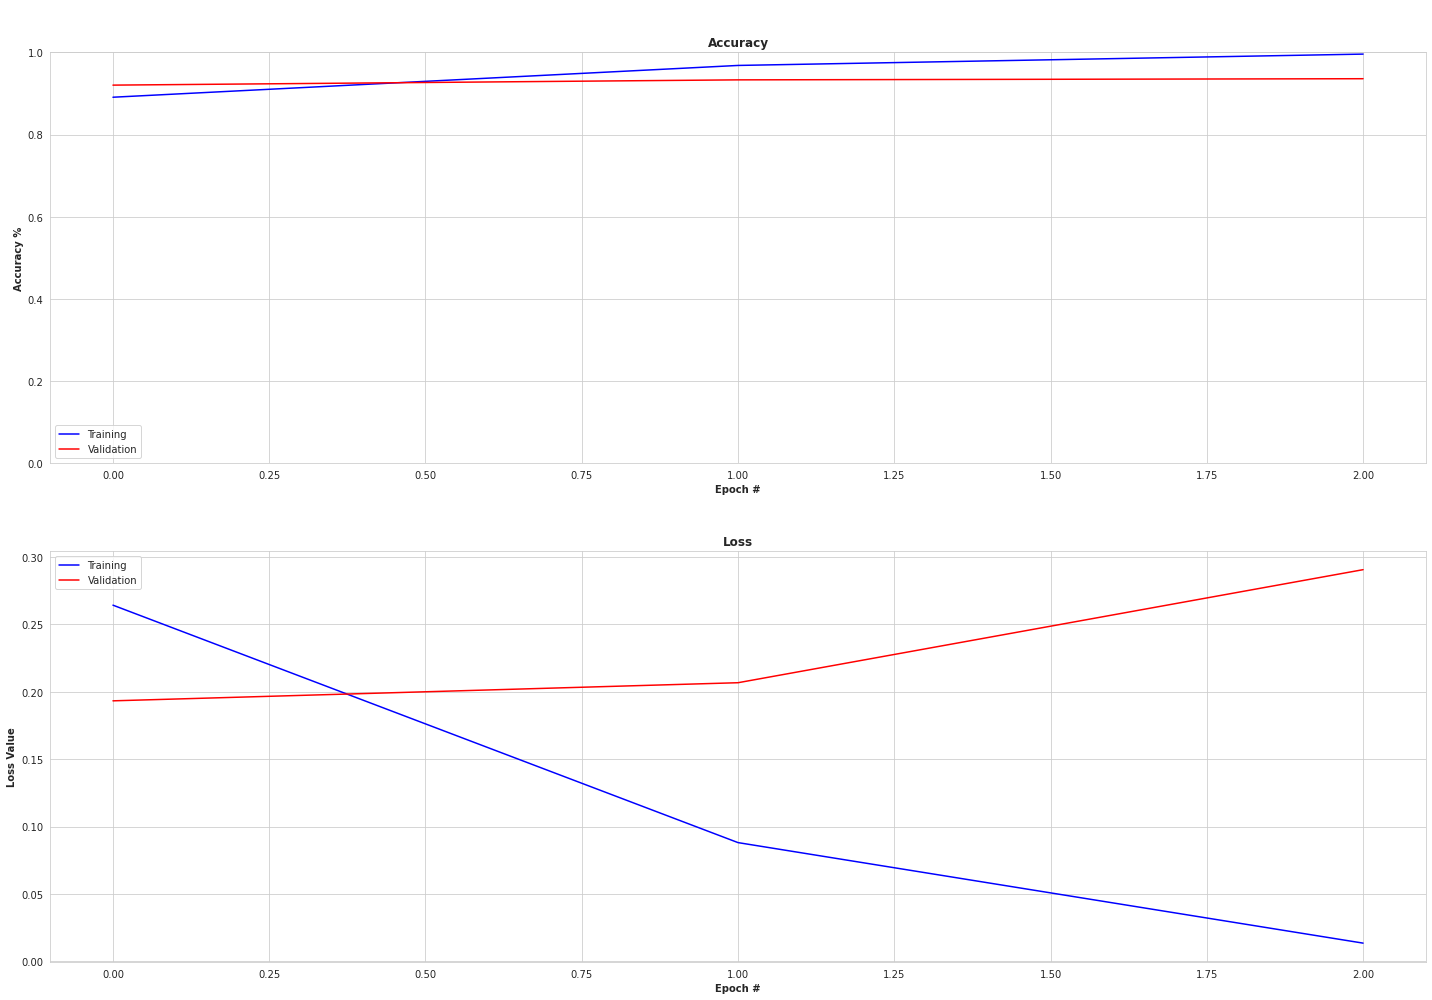

In [31]:
plt.figure(figsize=(20, 14))
plt.subplot(2, 1, 1)
plt.title("\n\nAccuracy", fontweight="bold")
l_1 = plt.plot(history.history["accuracy"], "-b", label="Training")
l_2 = plt.plot(history.history["val_accuracy"], "-r", label="Validation")
plt.ylim(0, 1.0)
plt.xlabel("Epoch #", fontweight="bold")
plt.ylabel("Accuracy %", fontweight="bold")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("\n\nLoss", fontweight="bold")
plt.plot(history.history["loss"], "-b", label="Training")
plt.plot(history.history["val_loss"], "-r", label="Validation")
plt.xlabel("Epoch #", fontweight="bold")
plt.ylabel("Loss Value", fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
joblib.dump(history, 'bert_model.pkl')

INFO:tensorflow:Assets written to: ram://2555b5be-31bb-4c3a-9a4f-6b81a62e423e/assets


INFO:tensorflow:Assets written to: ram://2555b5be-31bb-4c3a-9a4f-6b81a62e423e/assets


['bert_model.pkl']

The second model where I used bert is clearly a superior model with a validation accuracy of ~93%. I am still learning and improving on the use of transformers, and will keep making changes to this notebook to improve the models further.